<a href="https://colab.research.google.com/github/clerfayt28/Pitonchik/blob/main/Exam6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os
import numpy as np
import torch.nn.functional as F

In [17]:
import struct
import sys
from array import array
from os import path

train_dataset = torchvision.datasets.MNIST(root='./cache', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./cache', train=False, download=True)

def read(dataset):
    if dataset == "training":
        path_img = "./cache/MNIST/raw/train-images-idx3-ubyte"
        path_lbl = "./cache/MNIST/raw/train-labels-idx1-ubyte"
    elif dataset == "testing":
        path_img = "./cache/MNIST/raw/t10k-images-idx3-ubyte"
        path_lbl = "./cache/MNIST/raw/t10k-labels-idx1-ubyte"
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    with open(path_lbl, 'rb') as f_lable:
        __, size = struct.unpack(">II", f_lable.read(8))
        lbl = array("B", f_lable.read())

    with open(path_img, 'rb') as f_img:
        __, size, nrows, ncols = struct.unpack(">IIII", f_img.read(16))
        img = array("B", f_img.read())

    return lbl, img, size, nrows, ncols

def write_dataset(labels, data, size, rows, cols, output_dir):
    classes = {i: f"class{i}" for i in range(10)}

    output_dirs = [path.join(output_dir, classes[i]) for i in range(10)]

    for dir in output_dirs:
        dir = dir.replace("\\", "/")
        if not path.exists(dir):
            os.mkdir(dir)

    for (i, label) in enumerate(labels):
        output_filename = path.join(output_dirs[label], str(i) + ".jpg")
        print("Writing " + output_filename)

        with open(output_filename, "wb") as h:
            data_i = [
                data[ (i*rows*cols) + j*rows : (i*rows*cols) + (j+1)*rows ] for j in range(rows)
            ]
            data_array = np.asarray(data_i)

            im = Image.fromarray(data_array)


            im.save(output_filename)

for dataset in ["training", "testing"]:
    write_dataset(*read(dataset), path.join("data2", dataset))

Выходные данные были обрезаны до нескольких последних строк (5000).
Writing data2/testing/class3/5000.jpg
Writing data2/testing/class9/5001.jpg
Writing data2/testing/class9/5002.jpg
Writing data2/testing/class8/5003.jpg
Writing data2/testing/class4/5004.jpg
Writing data2/testing/class1/5005.jpg
Writing data2/testing/class0/5006.jpg
Writing data2/testing/class6/5007.jpg
Writing data2/testing/class0/5008.jpg
Writing data2/testing/class9/5009.jpg
Writing data2/testing/class6/5010.jpg
Writing data2/testing/class8/5011.jpg
Writing data2/testing/class6/5012.jpg
Writing data2/testing/class1/5013.jpg
Writing data2/testing/class1/5014.jpg
Writing data2/testing/class9/5015.jpg
Writing data2/testing/class8/5016.jpg
Writing data2/testing/class9/5017.jpg
Writing data2/testing/class2/5018.jpg
Writing data2/testing/class3/5019.jpg
Writing data2/testing/class5/5020.jpg
Writing data2/testing/class5/5021.jpg
Writing data2/testing/class9/5022.jpg
Writing data2/testing/class4/5023.jpg
Writing data2/testin

In [18]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# Hyper-parameters
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.001
class CustomImageDataset(Dataset):
    def __init__(self, dir_path):
        self.dir_path = dir_path

        self.len_dataset = 0
        self.data_list = []

        data_tree = os.walk(dir_path)
        for path_dir, dir_list, file_list in data_tree:
            if path_dir == dir_path:
                self.classes = dir_list
                self.class_to_index = {
                    class_name: i for i, class_name in enumerate(self.classes)
                }
                continue

            current_class = path_dir.split('/')[-1]

            for name in file_list:
                file_path = os.path.join(path_dir, name)
                self.data_list.append((file_path, self.class_to_index[current_class]))
            self.len_dataset += len(file_list)

    def __len__(self):
        return self.len_dataset
    def len(self):
        return self.len_dataset

    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        image = Image.open(file_path)
        image = transforms.ToTensor()(image)
        return image, target

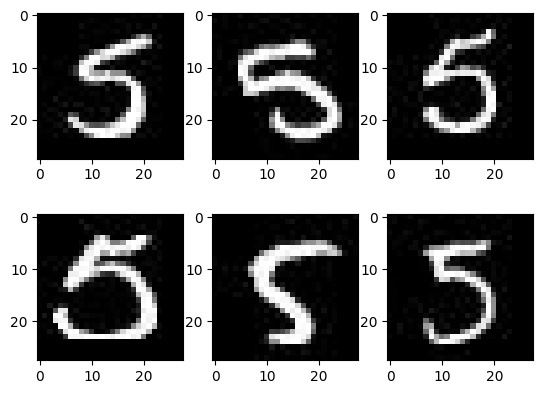

In [20]:
dataset_images = CustomImageDataset("data2/training")
dataloader_images = DataLoader(dataset=dataset_images, batch_size=64, shuffle=True)
dataset_testing = CustomImageDataset("data2/testing")
dataloader_testing = DataLoader(dataset=dataset_testing, batch_size=64, shuffle=False)

examples = iter(dataloader_testing)
example_data, example_targets = next(examples)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')

In [21]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [22]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
# Train the model
running_loss = 0.0
running_correct = 0
n_total_steps = len(dataloader_images)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader_images):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

class_labels = []
class_preds = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in dataloader_testing:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        values, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        class_probs_batch = [F.softmax(output, dim=0) for output in outputs]

        class_preds.append(class_probs_batch)
        class_labels.append(labels)
    class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
    class_labels = torch.cat(class_labels)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Epoch [1/1], Step [100/938], Loss: 0.4617
Epoch [1/1], Step [200/938], Loss: 0.1255
Epoch [1/1], Step [300/938], Loss: 0.1935
Epoch [1/1], Step [400/938], Loss: 0.1214
Epoch [1/1], Step [500/938], Loss: 0.2025
Epoch [1/1], Step [600/938], Loss: 0.1193
Epoch [1/1], Step [700/938], Loss: 0.3417
Epoch [1/1], Step [800/938], Loss: 0.1136
Epoch [1/1], Step [900/938], Loss: 0.0777
Accuracy of the network on the 10000 test images: 96.19 %
